### Chapter 7: Using Computer Vision and 2D Pose Estimation to Detect Surfer Stance

In [1]:
# import modules
import cv2
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import time
import sys
from tf_pose import common
from tf_pose.estimator import TfPoseEstimator
from tf_pose.networks import get_graph_path, model_wh

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.




In [2]:
# create a function that returns a point
def find_point(pose, p):
    for  point in pose:
        try:
            body_part = point.body_parts[p]
            return int(body_part.x * width + 0.5), int(body_part.y * height + 0.5)
        except:
            return 0, 0
    return 0, 0

In [3]:
# create a function that calculates Euclidian distance
def euclidian(point1, point2):
    return math.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)

In [4]:
# create a function that calculates the angle between three points
def angle_calc(p0, p1, p2):
    try:
        a = (p1[0] - p0[0])**2 + (p1[1] - p0[1])**2
        b = (p1[0] - p2[0])**2 + (p1[1] - p2[1])**2
        c = (p2[0] - p0[0])**2 + (p2[1] - p0[1])**2
        angle = math.acos((a + b - c) / math.sqrt(4 * a * b)) * 180 / math.pi
    except:
        return 0
    return int(angle)

In [5]:
# create a function that finds the center of mass
def center_of_mass(pose):
    joints = np.zeros([common.CocoPart.Background.value, 2])
    
    for p in pose:
        for i in range(common.CocoPart.Background.value):
            if i not in p.body_parts.keys():
                continue
            body_part = p.body_parts[i]
            joints[i] = [body_part.x, body_part.y]
    
    return np.mean(joints, axis=0)

#### Determine which foot the surfer puts forward

In [6]:
BOARD_STANCE_RIGHT = "Right foot is forward."
BOARD_STANCE_LEFT = "Left foot is forward."

# create a function that checks the angle between the head and hips
def surfing_check_board_stance(is_mirror, a, b):
    '''
        is_mirror: True if the camera is mirrored
        a:         neck left angle
        b:         neck right angle
    '''
    if not is_mirror:
        if a > b:
            return BOARD_STANCE_RIGHT
        return BOARD_STANCE_LEFT
    else:
        if a > b:
            return BOARD_STANCE_LEFT
        return BOARD_STANCE_RIGHT

In [7]:
# create a function that determines the stance
def detect_stance(is_mirror, pose):
    l = angle_calc(find_point(pose, 0), find_point(pose, 1), find_point(pose, 11))
    r = angle_calc(find_point(pose, 0), find_point(pose, 1), find_point(pose, 8))
    return surfing_check_board_stance(is_mirror, l, r)

In [8]:
# create a function that makes time stamped directories to save the results
def init_experiments_dir(experiments_dir='_experiments/'):
    if not os.path.exists(experiments_dir):
        os.makedirs(experiments_dir)
        
    time_stamp = time.strftime("%Y%m%d-%H%M%S")
    out_dir = experiments_dir + time_stamp
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)
        
    output_json = out_dir + "/json/"
    if not os.path.exists(output_json):
        os.makedirs(output_json)
    return out_dir, output_json

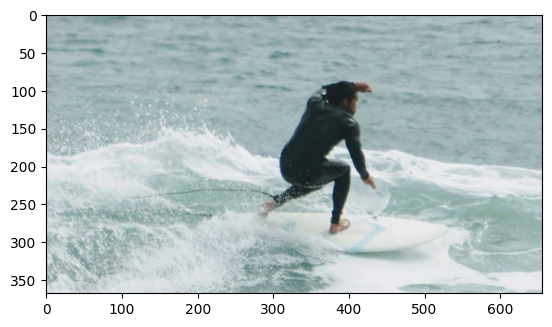

In [9]:
# create the experiments directory and load the initial image
out_dir, output_json = init_experiments_dir()

image_file = "media/surfer_656x368.jpg"
image = common.read_imgfile(image_file, None, None)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

In [10]:
# instantiate the estimator
e = TfPoseEstimator(get_graph_path('cmu'), target_size=(656, 368))

[2021-08-19 09:15:14,389] [TfPoseEstimator] [INFO] loading graph from C:\Users\dlpar\Anaconda3\envs\For_2D_Pose\lib\site-packages\tf_pose_data\graph/cmu/graph_opt.pb(default size=656x368)






TfPoseEstimator/Openpose/concat_stage7/axis
TfPoseEstimator/Mconv7_stage6_L2/biases
TfPoseEstimator/Mconv7_stage6_L2/weights
TfPoseEstimator/Mconv6_stage6_L2/biases
TfPoseEstimator/Mconv6_stage6_L2/weights
TfPoseEstimator/Mconv5_stage6_L2/biases
TfPoseEstimator/Mconv5_stage6_L2/weights
TfPoseEstimator/Mconv4_stage6_L2/biases
TfPoseEstimator/Mconv4_stage6_L2/weights
TfPoseEstimator/Mconv3_stage6_L2/biases
TfPoseEstimator/Mconv3_stage6_L2/weights
TfPoseEstimator/Mconv2_stage6_L2/biases
TfPoseEstimator/Mconv2_stage6_L2/weights
TfPoseEstimator/Mconv1_stage6_L2/biases
TfPoseEstimator/Mconv1_stage6_L2/weights
TfPoseEstimator/Mconv7_stage6_L1/biases
TfPoseEstimator/Mconv7_stage6_L1/weights
TfPoseEstimator/Mconv6_stage6_L1/biases
TfPoseEstimator/Mconv6_stage6_L1/weights
TfPoseEstimator/Mconv5_stage6_L1/biases
TfPoseEstimator/Mconv5_stage6_L1/weights
TfPoseEstimator/Mconv4_stage6_L1/biases
TfPoseEstimator/Mconv4_stage6_L1/weights
TfPoseEstimator/Mconv3_stage6_L1/biases
TfPoseEstimator/Mconv



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where





In [11]:
# start the inference and determine the stance
print('Inference started...')
t0 = time.time()

pose = e.inference(image, resize_to_default=True, upsample_size=4.0)

t1 = time.time()

print('Elapsed time: ', t1-t0)
print(detect_stance(True, pose))

Inference started...
Elapsed time:  1.0290851593017578
Right foot is forward.


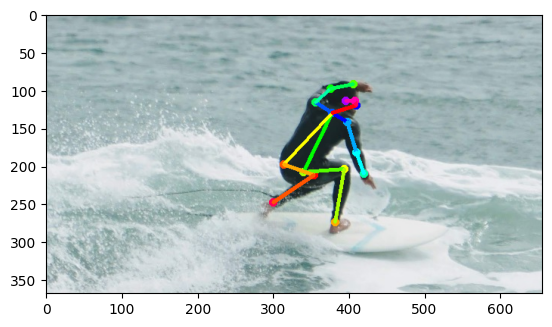

In [12]:
# display results
labeled_image = TfPoseEstimator.draw_humans(image, pose, imgcopy=False)
plt.imshow(cv2.cvtColor(labeled_image, cv2.COLOR_BGR2RGB))
plt.show()